In [129]:
import torch
import einops
import math
import time
import matplotlib.pyplot as plt

def dilated_attention_once(Q, K, dilated_rate):
    B, n_heads, T, d_head = Q.shape
    result = torch.ones(B, n_heads, T, T) * float('-inf')
    for i in range(n_heads):
        shift = i % dilated_rate
        result[:, i, shift::dilated_rate, shift::dilated_rate] = Q[:, i, shift::dilated_rate, :] @ K[:, i, :, shift::dilated_rate]

    return result

In [130]:
def dilated_attention(Q, K, segment_length, dilated_rate):
    # Q: B, n_heads, T, d_head
    # K: B, n_heads, d_head, T
    B, n_heads, T, d_head = Q.shape
    result = torch.ones(B, n_heads, T, T) * float('-inf')

    for i in range(T // segment_length + 1):
        result[:, :, i*segment_length:(i+1)*segment_length, i*segment_length:(i+1)*segment_length] = \
        dilated_attention_once(Q[:, :, i*segment_length:(i+1)*segment_length, :], K[:, :, :, i*segment_length:(i+1)*segment_length], dilated_rate)

    return result

In [131]:
def dilated_attention_full(Q, K):
    B, n_heads, T, d_head = Q.shape
    result = torch.ones(B, n_heads, T, T) * float('-inf')

    for X in range(int(math.log2(T))):
        segment_length = 2 ** (X+2)
        dilated_rate = 2 ** X
        
        result = torch.where(result < -1e5, dilated_attention(Q, K, segment_length=segment_length, dilated_rate=dilated_rate), result)

    return result

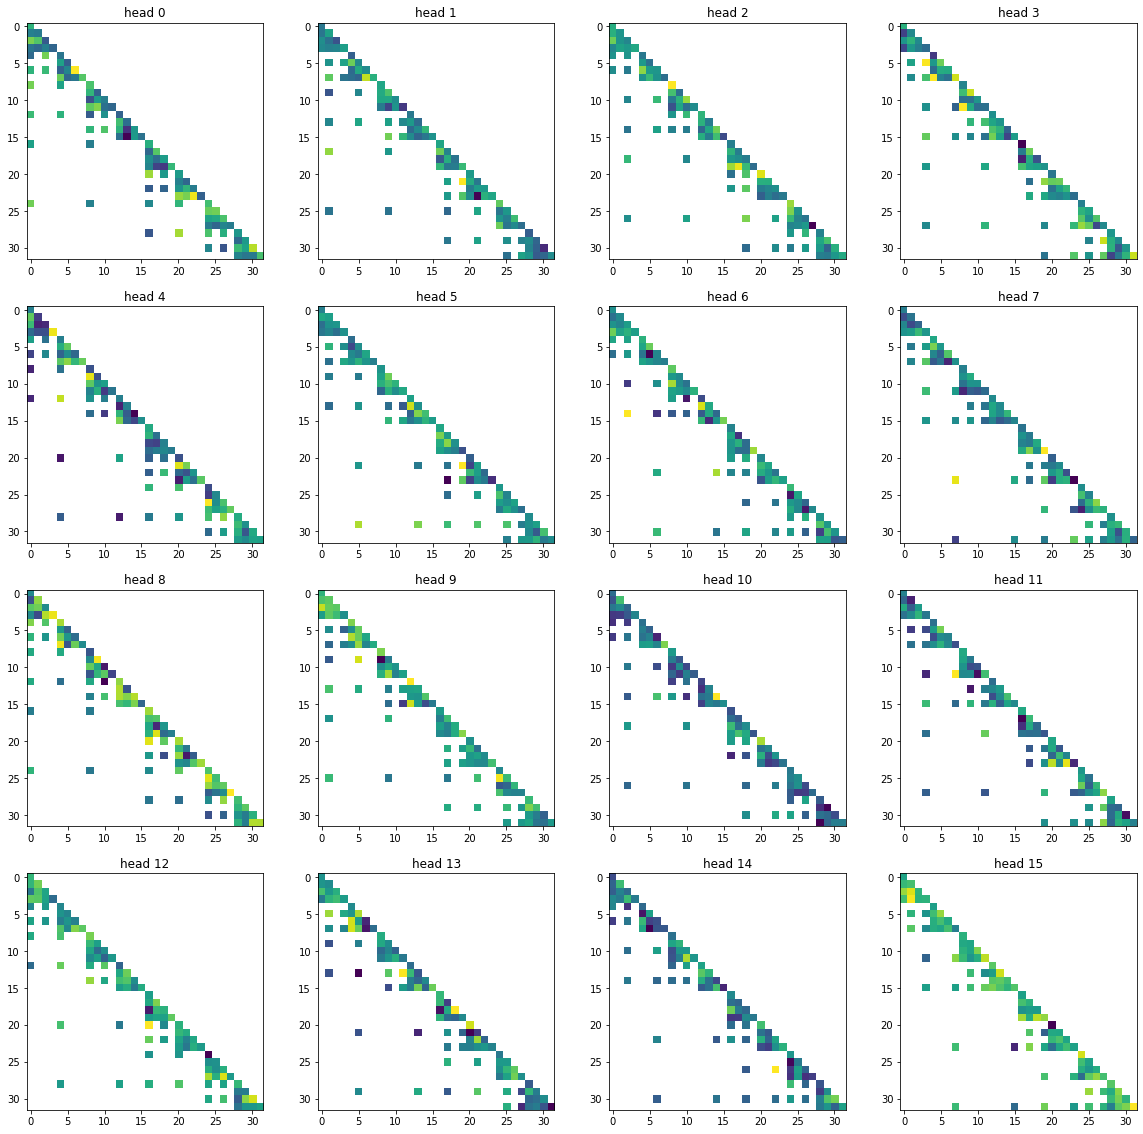

In [133]:
B, T, n_head, dim = 1, 32, 16, 16

Q = torch.randn(B, n_head, T, dim)
K = torch.randn(B, n_head, T, dim).transpose(-1, -2)

result = dilated_attention_full(Q, K) / (dim ** 0.5)
# result: (B, n_head, T, T)

mask = torch.tril(torch.ones(T, T))
result = result.masked_fill(mask == 0, float('-inf'))
# result = torch.nn.functional.softmax(result, dim=-1)

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i in range(n_head):
    ax[i//4][i%4].imshow(result[0, i].detach().numpy())
    ax[i//4][i%4].set_title(f'head {i}')

plt.show()